Device: cuda
Data shape: (155, 32)
Epoch 0, Loss 5.6983e+01, kept 32 features
Epoch 50, Loss 2.1620e-01, kept 32 features
Epoch 100, Loss 2.1185e-01, kept 32 features
Epoch 150, Loss 2.1213e-01, kept 32 features
Epoch 200, Loss 2.1533e-01, kept 32 features
Epoch 250, Loss 2.1580e-01, kept 32 features
Epoch 287, Loss 2.1532e-01, kept 32 features
Early stopping at epoch 287
Training done in 23.8s, best loss 2.1141e-01
Final MSE: 3.9774e-02, R2: 0.2192


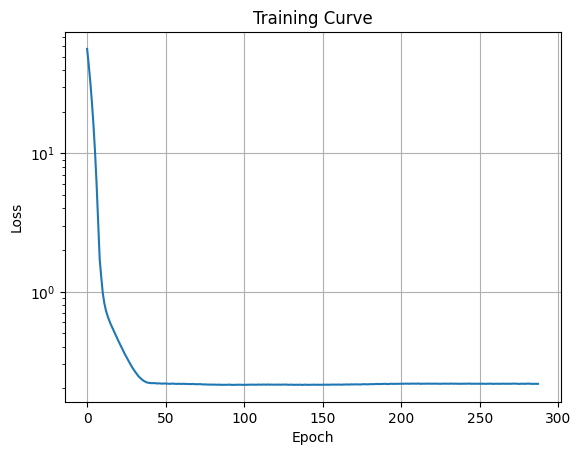

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from tqdm import tqdm
import time
from sklearn.decomposition import PCA

class SAEApproximatorPyTorch(nn.Module):
    """
    Linear (or optional 1-layer MLP) approximation from B -> A with elastic-net.
    Automatically filters out low-variance features by rebuilding the first layer.
    """
    def __init__(self, n_in, n_out, hidden_dim=2, device='cuda'):
        super().__init__()
        self.device = device
        self.hidden_dim = hidden_dim
        self.n_out = n_out
        # initial layer sizes; will be rebuilt after filtering
        self.initial_in = n_in
        self._build_model(n_in)
        # normalization stats
        self.register_buffer('B_mean', torch.zeros(n_in))
        self.register_buffer('B_std', torch.ones(n_in))
        self.register_buffer('A_mean', torch.zeros(n_out))
        self.register_buffer('A_std', torch.ones(n_out))
        self.normalize = False

    def _build_model(self, in_features):
        dims = [in_features, 1024, 512, self.n_out]
        layers = []
        for i in range(len(dims)-2):
            layers.append(nn.Linear(dims[i], dims[i+1]))
            layers.append(nn.GELU())
        layers.append(nn.Linear(dims[-2], dims[-1]))
        self.model = nn.Sequential(*layers).to(self.device)


    def forward(self, B):
        if self.normalize:
            B = (B - self.B_mean[:B.size(1)]) / (self.B_std[:B.size(1)] + 1e-8)
            A_pred = self.model(B)
            return A_pred * self.A_std + self.A_mean
        return self.model(B)

    def elastic_net_loss(self, A_pred, A_true, alpha, l1_ratio):
        mse = nn.functional.mse_loss(A_pred, A_true)
        l1 = sum(p.abs().sum() for p in self.model.parameters())
        l2 = sum((p**2).sum() for p in self.model.parameters())
        return mse + alpha * (l1_ratio * l1 + (1 - l1_ratio) * l2)

    def fit(self, A, B, alpha=0.01, l1_ratio=0.5, lr=1e-4,
            epochs=2000, batch_size=32, normalize=True,
            verbose=True, patience=150, var_thresh=1e-6):
        A = torch.as_tensor(A, dtype=torch.float32, device=self.device)
        B = torch.as_tensor(B, dtype=torch.float32, device=self.device)

        # filter low-variance features
        B_var = B.var(dim=0)
        keep_idx = (B_var > var_thresh).nonzero(as_tuple=True)[0]
        B = B[:, keep_idx]
        # rebuild model to match filtered input size
        self._build_model(len(keep_idx))

        if normalize:
            self.normalize = True
            self.B_mean = B.mean(dim=0)
            self.B_std = B.std(dim=0)
            self.A_mean = A.mean(dim=0)
            self.A_std = A.std(dim=0)

        loader = DataLoader(TensorDataset(B, A), batch_size=batch_size, shuffle=True)
        optimizer = optim.Adam(self.parameters(), lr=lr)

        best_loss, counter = float('inf'), 0
        history = []
        start = time.time()
        for epoch in range(epochs):
            epoch_loss = 0
            self.train()
            for bB, bA in loader:
                optimizer.zero_grad()
                pred = self.forward(bB)
                loss = self.elastic_net_loss(pred, bA, alpha, l1_ratio)
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()
            avg_loss = epoch_loss / len(loader)
            history.append(avg_loss)
            if avg_loss < best_loss:
                best_loss, counter = avg_loss, 0
            else:
                counter += 1
            if verbose and (epoch % 50 == 0 or counter == patience):
                print(f"Epoch {epoch}, Loss {avg_loss:.4e}, kept {len(keep_idx)} features")
            if counter >= patience:
                print(f"Early stopping at epoch {epoch}")
                break
        if verbose:
            print(f"Training done in {time.time()-start:.1f}s, best loss {best_loss:.4e}")
        self.keep_idx = keep_idx
        return history

    def predict(self, B):
        B = torch.as_tensor(B, dtype=torch.float32, device=self.device)
        B = B[:, self.keep_idx]
        self.eval()
        with torch.no_grad():
            out = self.forward(B)
        return out.cpu().numpy()

    def evaluate(self, A_true, B):
        A_true = np.asarray(A_true)
        A_pred = self.predict(B)
        return {'mse': np.mean((A_true - A_pred)**2), 'r2': r2_score(A_true, A_pred)}

# Example usage
if __name__ == '__main__':
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Device: {device}")

    data_A = torch.load('gemma2b_acts.pt')['gemma2b']
    data_B = torch.load('llama1b_acts.pt')['llama1b']
    B_list = [x.squeeze(0).mean(dim=0).cpu().numpy() for x in data_B]
    A_list = [x.squeeze(0).mean(dim=0).cpu().numpy() for x in data_A]
    B = np.stack(B_list)
    A = np.stack(A_list)
    pca_B = PCA(n_components=32)
    B_pca = pca_B.fit_transform(B)
    pca_A = PCA(n_components=32)
    A_pca = pca_A.fit_transform(A)
    print(f"Data shape: {B.shape}")

    model = SAEApproximatorPyTorch(n_in=B.shape[1], n_out=A.shape[1], hidden_dim=64, device=device)
    history = model.fit(A, B, alpha=0.001, l1_ratio=0.3, lr=5e-4,
                        epochs=300, batch_size=16, var_thresh=1e-5)

    res = model.evaluate(A, B)
    print(f"Final MSE: {res['mse']:.4e}, R2: {res['r2']:.4f}")

    plt.figure()
    plt.semilogy(history)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Curve')
    plt.grid(True)
    plt.show()

In [6]:
import joblib
torch.save(model.state_dict(), 'sae_model.pt')
#  4b) PCA transformer
joblib.dump(pca, 'pca_transform.pkl')
#  4c) keep_idx array
np.save('keep_idx.npy', model.keep_idx.cpu().numpy())

print("Saved: sae_model.pt, pca_transform.pkl, keep_idx.npy")

Saved: sae_model.pt, pca_transform.pkl, keep_idx.npy


In [12]:
import joblib
import numpy as np


# 2) Load new raw B data and PCA‑transform
data_B_new = torch.load('llama1b_acts.pt')['llama1b']
B_list_new = [x.squeeze(0).mean(dim=0).cpu().numpy() for x in data_B_new]
B_new_raw  = np.stack(B_list_new)            # (n_samples, raw_dim=16384)
B_pca_new  = pca_B.transform(B_new_raw)      # (n_samples, 32)

# 3) Reload model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = SAEApproximatorPyTorch(n_in=32, n_out=32, hidden_dim=64, device=device)
model.load_state_dict(torch.load('sae_model.pt', map_location=device))
model.eval()

# 4) **Restore** keep_idx onto the model
keep_idx = np.load('keep_idx.npy')                # shape (<=32,)
model.keep_idx = torch.from_numpy(keep_idx).long().to(device)

# 5) Now predict
A_pca_pred = model.predict(B_pca_new)             # shape (n_samples, 32)

# 6) Invert PCA for A back to raw space
A_raw_pred = pca_A.inverse_transform(A_pca_pred)  # shape (n_samples, 16384)

print("Predicted A in PCA space:", A_pca_pred.shape)
print("Predicted A in raw space:", A_raw_pred.shape)


Predicted A in PCA space: (155, 32)
Predicted A in raw space: (155, 16384)


In [13]:
A_raw_pred

array([[ 2.6091188e-01,  1.4251812e-02,  5.1000669e-08, ...,
         2.2996260e-01,  1.9202042e-02,  0.0000000e+00],
       [ 2.2126989e-01,  2.0547230e-02, -4.1891292e-07, ...,
         1.8473901e-01,  3.1083517e-02,  0.0000000e+00],
       [ 1.8658578e-01,  2.5990084e-02, -7.5957200e-07, ...,
         1.4280945e-01,  3.2341931e-02,  0.0000000e+00],
       ...,
       [-1.3492608e-01,  7.5424150e-02, -3.8732605e-06, ...,
        -2.2858180e-01,  9.4646007e-02,  0.0000000e+00],
       [-7.3585093e-02,  6.7098267e-02, -3.2346350e-06, ...,
        -1.7201941e-01,  8.4398516e-02,  0.0000000e+00],
       [ 2.2677235e-01,  1.6420534e-02, -1.7335392e-07, ...,
         1.7248389e-01,  2.5624707e-02,  0.0000000e+00]], dtype=float32)